<a href="https://colab.research.google.com/github/YagyanshB/nhs-data-science/blob/main/leeds_teaching_nhs_trust_random_forest_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing required libraries

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# setting random seed for reproducibility

np.random.seed(42)
random.seed(42)

In [13]:
# Generating synthetic NHS patient dataset with key readmission predictors

def generate_nhs_patient_data(n_patients=100000):
    # NHS Number (10 digits)
    nhs_numbers = [f"{random.randint(100_000_0000, 999_999_9999)}" for _ in range(n_patients)]

    # Demographics
    ages = np.random.randint(18, 95, size=n_patients)
    genders = np.random.choice(['Male', 'Female'], size=n_patients)

    # Ethnicity
    ethnicities = np.random.choice([
        'White British', 'White Other', 'Asian/Asian British',
        'Black/Black British', 'Mixed', 'Other'
    ], size=n_patients, p=[0.8, 0.05, 0.07, 0.03, 0.02, 0.03])  # Approximate UK demographics

    # Indices of Multiple Deprivation (IMD) quintile (1=most deprived, 5=least deprived)
    imd_quintile = np.random.randint(1, 6, size=n_patients)

    # Clinical factors
    diagnoses = np.random.choice([
        'Heart Failure', 'Pneumonia', 'COPD', 'Diabetes',
        'Sepsis', 'Stroke', 'UTI', 'Renal Failure', 'Mental Health',
        'Frailty', 'Cancer', 'GI Bleed'
    ], size=n_patients)

    # Length of stay
    length_of_stay = np.random.exponential(scale=4, size=n_patients).astype(int) + 1
    length_of_stay = np.clip(length_of_stay, 1, 30)  # Clip to realistic range

    # Previous admissions in last 12 months
    previous_admissions = np.random.randint(0, 6, size=n_patients)

    # Admission method
    admission_method = np.random.choice([
        'Emergency - A&E', 'Emergency - GP Referral', 'Elective',
        'Transfer from other trust', 'Maternity'
    ], size=n_patients, p=[0.65, 0.15, 0.15, 0.04, 0.01])
    emergency_admission = np.isin(admission_method, ['Emergency - A&E', 'Emergency - GP Referral'])

    # Charlson Comorbidity Index (0-10)
    charlson_index = np.random.randint(0, 11, size=n_patients)

    # NEWS2 Score at discharge (National Early Warning Score) (0-20)
    news2_score = np.random.randint(0, 11, size=n_patients)

    # Discharge destination - NHS terminology
    discharge_destination = np.random.choice([
        'Usual place of residence', 'Care Home', 'Other NHS Hospital',
        'Hospice', 'Died', 'Other'
    ], size=n_patients, p=[0.8, 0.08, 0.05, 0.02, 0.04, 0.01])

    # Whether patient has a GP follow-up appointment
    gp_followup = np.random.choice([True, False], size=n_patients, p=[0.7, 0.3])

    # Polypharmacy (5+ medications)
    polypharmacy = np.random.choice([True, False], size=n_patients)

    # Calculate readmission risk based on key NHS factors
    readmission_risk = (
        0.1 * (ages > 75).astype(int) +  # Age > 75 (UK focus on elderly)
        0.1 * (imd_quintile < 3).astype(int) +  # Higher deprivation
        0.15 * (previous_admissions > 0).astype(int) +  # Any previous admission
        0.2 * (np.isin(diagnoses, ['Heart Failure', 'COPD', 'Frailty', 'Mental Health'])).astype(int) +  # High-risk diagnoses
        0.1 * (length_of_stay > 7).astype(int) +  # Extended stay
        0.15 * (charlson_index > 3).astype(int) +  # Higher comorbidity index
        0.1 * (news2_score > 3).astype(int) +  # Elevated NEWS2 score
        0.05 * emergency_admission.astype(int) +  # Emergency admission
        0.1 * (np.isin(discharge_destination, ['Care Home', 'Other NHS Hospital'])).astype(int) +  # Non-home discharge
        0.05 * (~gp_followup).astype(int) +  # No GP follow-up
        0.1 * polypharmacy.astype(int) +  # Polypharmacy
        np.random.normal(0, 0.1, size=n_patients)  # Random noise
    )

    # Clipping the probabilities between 0 and 1
    readmission_risk = np.clip(readmission_risk, 0, 1)

    # Apply higher baseline for specific categories to model UK readmission patterns
    # E.g., 30-day readmission rate is around 13.8% in the NHS
    readmission_risk = readmission_risk * 1.2
    readmission_risk = np.clip(readmission_risk, 0, 1)

    # Generate readmission within 30 days (standard NHS metric)
    is_readmitted_30d = np.random.binomial(1, readmission_risk)

    # Creating DataFrame
    df = pd.DataFrame({
        'nhs_number': nhs_numbers,
        'age': ages,
        'gender': genders,
        'ethnicity': ethnicities,
        'imd_quintile': imd_quintile,
        'primary_diagnosis': diagnoses,
        'length_of_stay': length_of_stay,
        'previous_admissions_12mo': previous_admissions,
        'admission_method': admission_method,
        'emergency_admission': emergency_admission,
        'charlson_index': charlson_index,
        'news2_score': news2_score,
        'discharge_destination': discharge_destination,
        'gp_followup': gp_followup,
        'polypharmacy': polypharmacy,
        'readmission_risk': readmission_risk,
        'readmitted_within_30d': is_readmitted_30d
    })

    return df

In [14]:
# Generating and saving dataset
nhs_patient_data = generate_nhs_patient_data(100000)
nhs_patient_data.to_csv('nhs_patient_data.csv', index=False)

# Displaying summary
print(f"NHS dataset created with {len(nhs_patient_data)} patients")
print(f"30-day readmission rate: {nhs_patient_data['readmitted_within_30d'].mean():.2%}")
print("\nSample data:")
print(nhs_patient_data.head())

# Displaying key correlations with readmission
correlations = nhs_patient_data.drop(columns=['nhs_number', 'gender', 'ethnicity', 'primary_diagnosis',
                                            'admission_method', 'discharge_destination']).corr()['readmitted_within_30d'].sort_values(ascending=False)
print("\nFeature correlations with 30-day readmission:")
print(correlations)

# Additional NHS-specific analysis
print("\nReadmission rates by deprivation quintile:")
for quintile in range(1, 6):
    subset = nhs_patient_data[nhs_patient_data['imd_quintile'] == quintile]
    print(f"IMD Quintile {quintile}: {subset['readmitted_within_30d'].mean():.2%}")

print("\nReadmission rates by discharge destination:")
for destination in nhs_patient_data['discharge_destination'].unique():
    subset = nhs_patient_data[nhs_patient_data['discharge_destination'] == destination]
    print(f"{destination}: {subset['readmitted_within_30d'].mean():.2%}")

NHS dataset created with 100000 patients
30-day readmission rate: 65.24%

Sample data:
   nhs_number  age  gender            ethnicity  imd_quintile  \
0  8455713012   24  Female        White British             2   
1  4650287915   81  Female        White British             5   
2  1499304460   83    Male  Asian/Asian British             5   
3  4909715284   79  Female        White British             1   
4  6009947274   66  Female        White British             3   

  primary_diagnosis  length_of_stay  previous_admissions_12mo  \
0     Renal Failure               7                         4   
1     Heart Failure               5                         0   
2            Cancer               1                         5   
3          Diabetes               2                         1   
4     Mental Health               5                         0   

          admission_method  emergency_admission  charlson_index  news2_score  \
0          Emergency - A&E                 True    

Loading data...
Dataset loaded with 500 patients
30-day readmission rate: 64.20%
Training set: 400 samples
Testing set: 100 samples
Categorical features: ['gender', 'ethnicity', 'primary_diagnosis', 'admission_method', 'emergency_admission', 'discharge_destination', 'gp_followup', 'polypharmacy']
Numerical features: ['age', 'imd_quintile', 'length_of_stay', 'previous_admissions_12mo', 'charlson_index', 'news2_score']

Training model...

Evaluating model...
Test ROC AUC: 0.6821

Classification report:
              precision    recall  f1-score   support

           0       0.52      0.30      0.38        37
           1       0.67      0.84      0.75        63

    accuracy                           0.64       100
   macro avg       0.60      0.57      0.56       100
weighted avg       0.62      0.64      0.61       100


Top 10 important features:
age: 0.1271
charlson_index: 0.0980
news2_score: 0.0933
length_of_stay: 0.0860
previous_admissions_12mo: 0.0753
imd_quintile: 0.0674
polypha

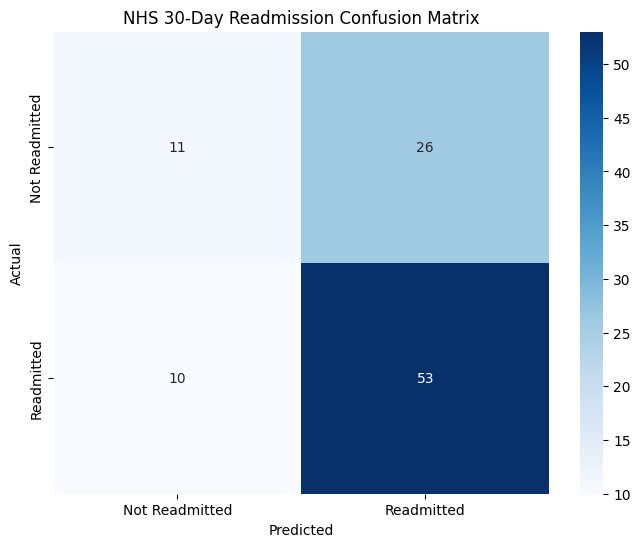

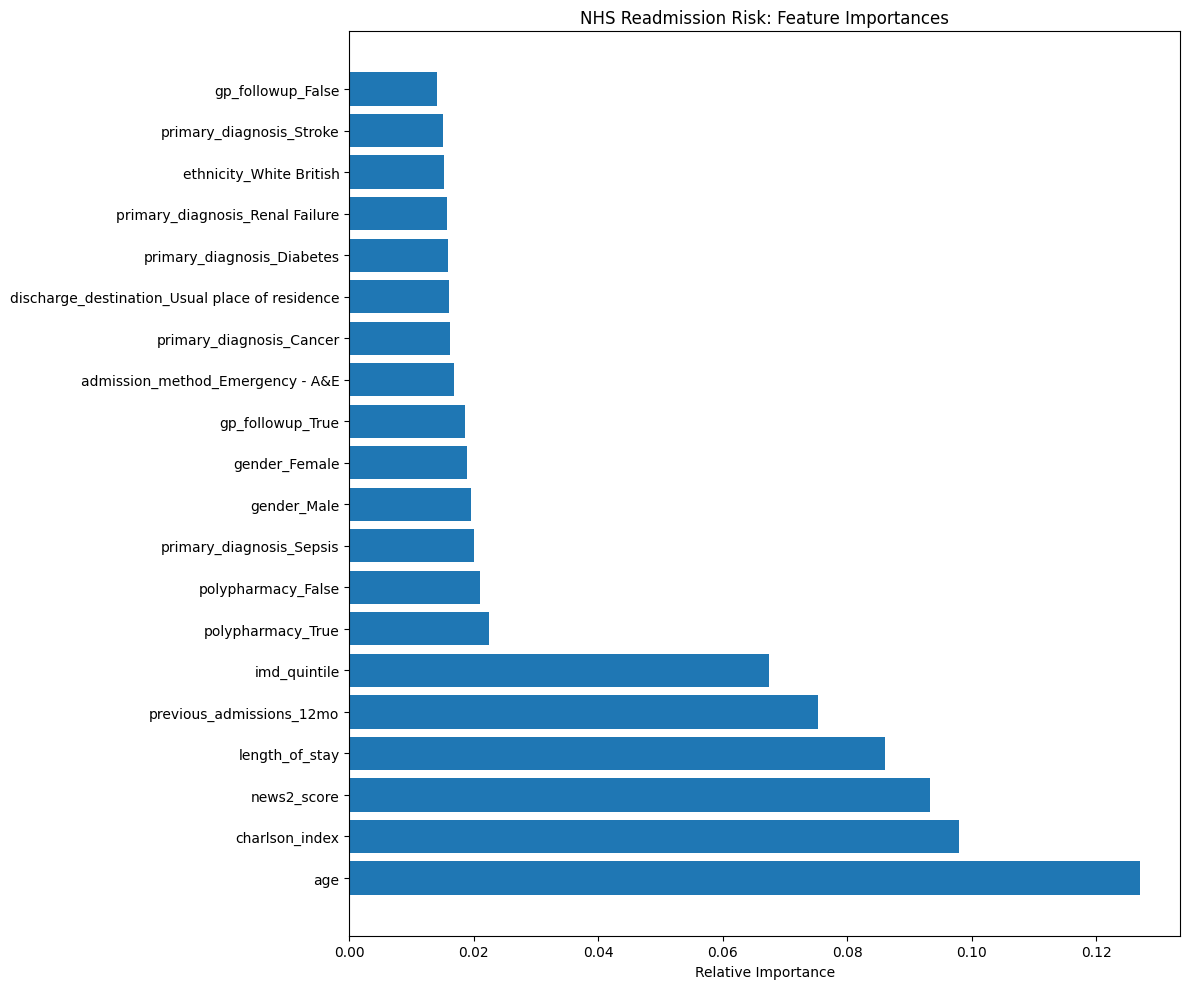

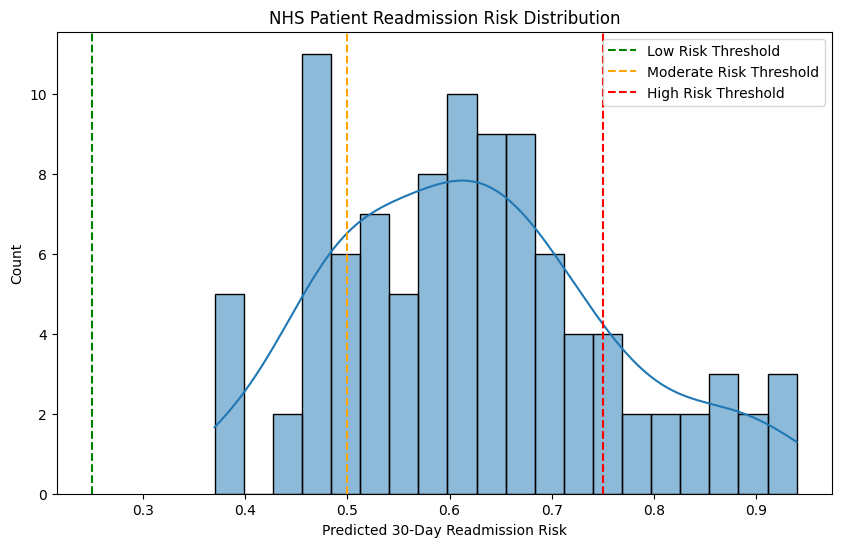

In [12]:
# Load the data
print("Loading data...")
data = pd.read_csv('nhs_patient_data.csv')
print(f"Dataset loaded with {len(data)} patients")
print(f"30-day readmission rate: {data['readmitted_within_30d'].mean():.2%}")

# Define features and target
X = data.drop(['nhs_number', 'readmission_risk', 'readmitted_within_30d'], axis=1)
y = data['readmitted_within_30d']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features: {categorical_cols}")
print(f"Numerical features: {numerical_cols}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
print("\nTraining model...")
model.fit(X_train, y_train)

# Evaluate on test set
print("\nEvaluating model...")
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Calculate metrics
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Test ROC AUC: {auc:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('NHS 30-Day Readmission Confusion Matrix')
plt.savefig('nhs_confusion_matrix.png')

# Feature importance
if hasattr(model[-1], 'feature_importances_'):
    # Get feature names after preprocessing
    preprocessed_features = []
    # Add encoded categorical features
    for i, col in enumerate(categorical_cols):
        categories = model[0].named_transformers_['cat'].categories_[i]
        for cat in categories:
            preprocessed_features.append(f"{col}_{cat}")
    # Add numerical features
    preprocessed_features.extend(numerical_cols)

    # Get feature importances
    importances = model[-1].feature_importances_

    # Sort features by importance
    indices = np.argsort(importances)[::-1]

    # Plot feature importances
    plt.figure(figsize=(12, 10))
    plt.title('NHS Readmission Risk: Feature Importances')
    plt.barh(range(min(20, len(indices))), importances[indices][:20], align='center')
    plt.yticks(range(min(20, len(indices))), [preprocessed_features[i] for i in indices][:20])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig('nhs_feature_importance.png')

    # Print top 10 features
    print("\nTop 10 important features:")
    for i in range(min(10, len(indices))):
        print(f"{preprocessed_features[indices[i]]}: {importances[indices[i]]:.4f}")

# Creating a prediction function with NHS-specific factors
def predict_nhs_readmission_risk(patient_data):
    """
    Predict 30-day readmission risk for an NHS patient

    Args:
        patient_data: Dictionary with patient features

    Returns:
        Dictionary with risk prediction and key factors
    """
    # Convert to DataFrame if needed
    if not isinstance(patient_data, pd.DataFrame):
        patient_data = pd.DataFrame([patient_data])

    # Get prediction
    risk_prob = model.predict_proba(patient_data)[0, 1]
    risk_score = int(round(risk_prob * 100))

    # Determine risk category
    if risk_score < 25:
        risk_category = "Low"
    elif risk_score < 50:
        risk_category = "Moderate"
    elif risk_score < 75:
        risk_category = "High"
    else:
        risk_category = "Very High"

    # Identify key risk factors using NHS-specific indicators
    key_factors = []

    if patient_data['age'].values[0] > 75:
        key_factors.append("Advanced age (>75)")

    if patient_data['imd_quintile'].values[0] <= 2:
        key_factors.append(f"High deprivation (IMD quintile {patient_data['imd_quintile'].values[0]})")

    if patient_data['previous_admissions_12mo'].values[0] > 0:
        key_factors.append(f"{patient_data['previous_admissions_12mo'].values[0]} previous admission(s) in last 12 months")

    high_risk_dx = ['Heart Failure', 'COPD', 'Frailty', 'Mental Health']
    if patient_data['primary_diagnosis'].values[0] in high_risk_dx:
        key_factors.append(f"High-risk diagnosis: {patient_data['primary_diagnosis'].values[0]}")

    if patient_data['length_of_stay'].values[0] > 7:
        key_factors.append("Extended hospital stay (>7 days)")

    if patient_data['charlson_index'].values[0] > 3:
        key_factors.append(f"High Charlson index ({patient_data['charlson_index'].values[0]})")

    if patient_data['news2_score'].values[0] > 3:
        key_factors.append(f"Elevated NEWS2 score ({patient_data['news2_score'].values[0]})")

    if patient_data['emergency_admission'].values[0]:
        key_factors.append("Emergency admission")

    if patient_data['discharge_destination'].values[0] in ['Care Home', 'Other NHS Hospital']:
        key_factors.append(f"Discharge to {patient_data['discharge_destination'].values[0]}")

    if not patient_data['gp_followup'].values[0]:
        key_factors.append("No GP follow-up arranged")

    if patient_data['polypharmacy'].values[0]:
        key_factors.append("Polypharmacy (5+ medications)")

    return {
        "risk_probability": float(risk_prob),
        "risk_score": risk_score,
        "risk_category": risk_category,
        "key_factors": key_factors
    }

# Test the prediction function on a sample patient
sample_patient = X_test.iloc[0].to_dict()
prediction = predict_nhs_readmission_risk(sample_patient)
print("\nSample NHS patient prediction:")
print(f"Risk score: {prediction['risk_score']}")
print(f"Risk category: {prediction['risk_category']}")
print(f"Key factors: {', '.join(prediction['key_factors'])}")
print(f"Actual outcome: {'Readmitted' if y_test.iloc[0] else 'Not readmitted'}")

# Additional NHS-specific analysis
print("\nReadmission risk by IMD quintile:")
for quintile in range(1, 6):
    subset_X = X_test[X_test['imd_quintile'] == quintile]
    subset_y = y_test[X_test['imd_quintile'] == quintile]
    if len(subset_X) > 0:
        subset_pred = model.predict_proba(subset_X)[:, 1]
        subset_auc = roc_auc_score(subset_y, subset_pred)
        print(f"IMD Quintile {quintile}: AUC = {subset_auc:.4f}, Mean Risk = {subset_pred.mean():.2%}")

print("\nReadmission risk by age group:")
age_groups = [(18, 44), (45, 64), (65, 74), (75, 84), (85, 95)]
for low, high in age_groups:
    subset_X = X_test[(X_test['age'] >= low) & (X_test['age'] <= high)]
    subset_y = y_test[(X_test['age'] >= low) & (X_test['age'] <= high)]
    if len(subset_X) > 0:
        subset_pred = model.predict_proba(subset_X)[:, 1]
        subset_auc = roc_auc_score(subset_y, subset_pred)
        print(f"Age {low}-{high}: AUC = {subset_auc:.4f}, Mean Risk = {subset_pred.mean():.2%}")

# Create risk score distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_prob, bins=20, kde=True)
plt.axvline(0.25, color='green', linestyle='--', label='Low Risk Threshold')
plt.axvline(0.5, color='orange', linestyle='--', label='Moderate Risk Threshold')
plt.axvline(0.75, color='red', linestyle='--', label='High Risk Threshold')
plt.xlabel('Predicted 30-Day Readmission Risk')
plt.ylabel('Count')
plt.title('NHS Patient Readmission Risk Distribution')
plt.legend()
plt.savefig('nhs_risk_distribution.png')

# Save the model
print("\nSaving model...")
joblib.dump(model, 'nhs_readmission_model.pkl')
print("NHS readmission model saved successfully")

In [15]:
# 1.1 Load the NHS patient dataset we created
print("Loading NHS patient data...")
data = pd.read_csv('nhs_patient_data.csv')
print(f"Loaded {len(data)} NHS patients.")

# 1.2 Creating synthetic NHS clinical notes based on patient attributes
def generate_nhs_clinical_note(diagnosis, charlson_index, emergency_admission, news2_score,
                              ethnicity, imd_quintile, discharge_destination, polypharmacy, age):
    notes = []

    # Primary diagnosis notes - NHS terminology
    if diagnosis == 'Heart Failure':
        notes.append("Patient presents with progressive dyspnoea and peripheral oedema.")
    elif diagnosis == 'COPD':
        notes.append("Patient with history of COPD presenting with increased SOB and sputum production.")
    elif diagnosis == 'Pneumonia':
        notes.append("CXR shows consolidation, commenced on Trust CAP protocol.")
    elif diagnosis == 'Diabetes':
        notes.append("Poor glycaemic control, HbA1c of 86 mmol/mol.")
    elif diagnosis == 'Sepsis':
        notes.append("Patient triggered sepsis pathway. Blood cultures taken and IV antibiotics commenced as per Trust guidelines.")
    elif diagnosis == 'Stroke':
        notes.append("Right-sided weakness and dysphasia. CT head performed, stroke team consulted.")
    elif diagnosis == 'UTI':
        notes.append("Positive urine dipstick with nitrites. MSU sent to micro.")
    elif diagnosis == 'Renal Failure':
        notes.append("AKI stage 2 with creatinine 250 μmol/L, fluid balance chart initiated.")
    elif diagnosis == 'Mental Health':
        notes.append("Low mood and anxiety reported. Mental health liaison team consulted.")
    elif diagnosis == 'Frailty':
        notes.append("Clinical Frailty Score 6. Falls risk assessment completed.")
    elif diagnosis == 'Cancer':
        notes.append("Under care of oncology team at specialist centre. Palliative care team involved.")
    elif diagnosis == 'GI Bleed':
        notes.append("Melaena reported. Hb 84 g/L. Urgent endoscopy requested.")

    # Comorbidity factor - using Charlson index
    if charlson_index > 3:
        notes.append("Multiple comorbidities increasing clinical complexity.")

    # Emergency admission
    if emergency_admission:
        notes.append("Admitted via A&E. Initial assessment completed by acute medical team.")

    # NEWS2 score - NHS specific
    if news2_score > 5:
        notes.append(f"NEWS2 score {news2_score}. Escalated to medical registrar.")
    elif news2_score > 3:
        notes.append(f"NEWS2 score {news2_score}. Observations increased to 4-hourly.")

    # Social factors - NHS specific
    if imd_quintile <= 2:
        social_notes = [
            "Social care needs identified. Referral to hospital social worker.",
            "Housing concerns noted. Living in temporary accommodation.",
            "Food insecurity reported. Referred to community support services."
        ]
        notes.append(random.choice(social_notes))

    # Discharge planning - NHS specific
    if discharge_destination == 'Care Home':
        notes.append("For discharge to care home when medically fit. FNC assessment requested.")
    elif discharge_destination == 'Other NHS Hospital':
        notes.append("For transfer to community hospital for rehabilitation when bed available.")
    elif discharge_destination == 'Usual place of residence':
        notes.append("Home assessment visit may be required before discharge.")
    elif discharge_destination == 'Hospice':
        notes.append("Referral made to local hospice. Awaiting bed availability.")

    # Medication factors
    if polypharmacy:
        notes.append("Multiple medications. Pharmacy medication review completed.")

    # Age-related notes
    if age > 85:
        elderly_notes = [
            "Consider for CGA prior to discharge.",
            "Dementia screening completed.",
            "DNAR form completed after discussion with patient and family."
        ]
        notes.append(random.choice(elderly_notes))

    # Random extra sentence for realism - NHS specific
    random_notes = [
        "Family meeting arranged with ward sister.",
        "Poor compliance with medication reported.",
        "Mobility assessment completed by ward physiotherapist.",
        "Last set of observations stable.",
        "Patient information leaflet provided.",
        "District nurse referral to be completed prior to discharge.",
        "Patient enrolled in virtual ward pathway.",
        "Capacity assessment completed.",
        "Patient has advance care plan in place.",
        "GP updated via discharge summary."
    ]
    notes.append(random.choice(random_notes))

    return " ".join(notes)

# 1.3 Apply note generation with NHS-specific parameters
data['clinical_note'] = data.apply(
    lambda row: generate_nhs_clinical_note(
        row['primary_diagnosis'],
        row['charlson_index'],
        row['emergency_admission'],
        row['news2_score'],
        row['ethnicity'],
        row['imd_quintile'],
        row['discharge_destination'],
        row['polypharmacy'],
        row['age']
    ),
    axis=1
)

# 1.4 Save dataset
data.to_csv('nhs_patient_data_with_notes.csv', index=False)
print("✅ NHS clinical notes added and saved to 'nhs_patient_data_with_notes.csv'.")

print("\nSample NHS clinical notes:")
print(data[['primary_diagnosis', 'clinical_note']].head())

# 1.5 Analyze note characteristics
print("\nNote length statistics:")
data['note_length'] = data['clinical_note'].str.len()
print(f"Average note length: {data['note_length'].mean():.1f} characters")
print(f"Min note length: {data['note_length'].min()} characters")
print(f"Max note length: {data['note_length'].max()} characters")

# 1.6 Count most common words/phrases in notes
from collections import Counter
import re

# Tokenize notes (simple approach)
all_notes = " ".join(data['clinical_note'].tolist()).lower()
words = re.findall(r'\b[a-z]{3,}\b', all_notes)  # Simple tokenization of words with at least 3 letters
word_counts = Counter(words).most_common(15)

print("\nMost common words in clinical notes:")
for word, count in word_counts:
    print(f"{word}: {count}")

# 1.7 Create a sample discharge summary for a high-risk patient
high_risk_patients = data[data['readmission_risk'] > 0.7].sample(1)
patient = high_risk_patients.iloc[0]

discharge_summary = f"""
NHS HOSPITAL TRUST
DISCHARGE SUMMARY

NHS Number: {patient['nhs_number']}
Date of Discharge: {datetime.now().strftime('%d/%m/%Y')}

PATIENT DETAILS:
Age: {patient['age']}
Gender: {patient['gender']}
Ethnicity: {patient['ethnicity']}
IMD Quintile: {patient['imd_quintile']}

ADMISSION DETAILS:
Primary Diagnosis: {patient['primary_diagnosis']}
Admission Method: {patient['admission_method']}
Length of Stay: {patient['length_of_stay']} days
NEWS2 Score at Discharge: {patient['news2_score']}

CLINICAL SUMMARY:
{patient['clinical_note']}

RISK ASSESSMENT:
Charlson Comorbidity Index: {patient['charlson_index']}
Polypharmacy: {'Yes' if patient['polypharmacy'] else 'No'}
Previous admissions in last 12 months: {patient['previous_admissions_12mo']}
Readmission Risk: High

FOLLOW-UP PLAN:
GP follow-up: {'Arranged' if patient['gp_followup'] else 'Not arranged'}
District Nurse: Referral made
Medications: See attached prescription

ACTIONS FOR GP:
- Review medication within 1 week
- Check renal function in 5-7 days
- Post-discharge telephone assessment recommended
"""

print("\nSample NHS Discharge Summary for High-Risk Patient:")
print(discharge_summary)

Loading NHS patient data...
Loaded 100000 NHS patients.
✅ NHS clinical notes added and saved to 'nhs_patient_data_with_notes.csv'.

Sample NHS clinical notes:
  primary_diagnosis                                      clinical_note
0     Renal Failure  AKI stage 2 with creatinine 250 μmol/L, fluid ...
1     Heart Failure  Patient presents with progressive dyspnoea and...
2            Cancer  Under care of oncology team at specialist cent...
3          Diabetes  Poor glycaemic control, HbA1c of 86 mmol/mol. ...
4     Mental Health  Low mood and anxiety reported. Mental health l...

Note length statistics:
Average note length: 348.0 characters
Min note length: 78 characters
Max note length: 580 characters

Most common words in clinical notes:
assessment: 196096
completed: 176012
medical: 125193
multiple: 113732
team: 112913
discharge: 111893
via: 89790
home: 88036
visit: 80059
may: 80059
required: 80059
before: 80059
admitted: 79770
initial: 79770
acute: 79770

Sample NHS Discharge Summary

Loading NHS dataset...
Loaded 100000 NHS patients with clinical notes
Creating TF-IDF features from NHS clinical notes...
Created 240 text features
Encoding 8 categorical columns: ['gender', 'ethnicity', 'primary_diagnosis', 'admission_method', 'emergency_admission', 'discharge_destination', 'gp_followup', 'polypharmacy']
Combined feature space dimensions: 43 structured + 240 text = 283 total features

Training NHS combined model (structured + text features)...

Evaluating NHS combined model...
ROC AUC: 0.6852

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.40      0.46      6935
           1       0.72      0.82      0.76     13065

    accuracy                           0.67     20000
   macro avg       0.63      0.61      0.61     20000
weighted avg       0.65      0.67      0.66     20000

✅ NHS combined model confusion matrix saved.

Training NHS structured-only model for comparison...

Model comparison:
Structured-only

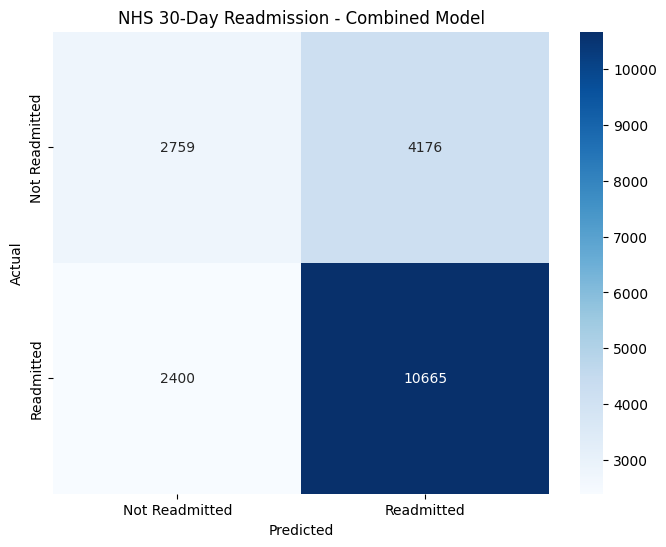

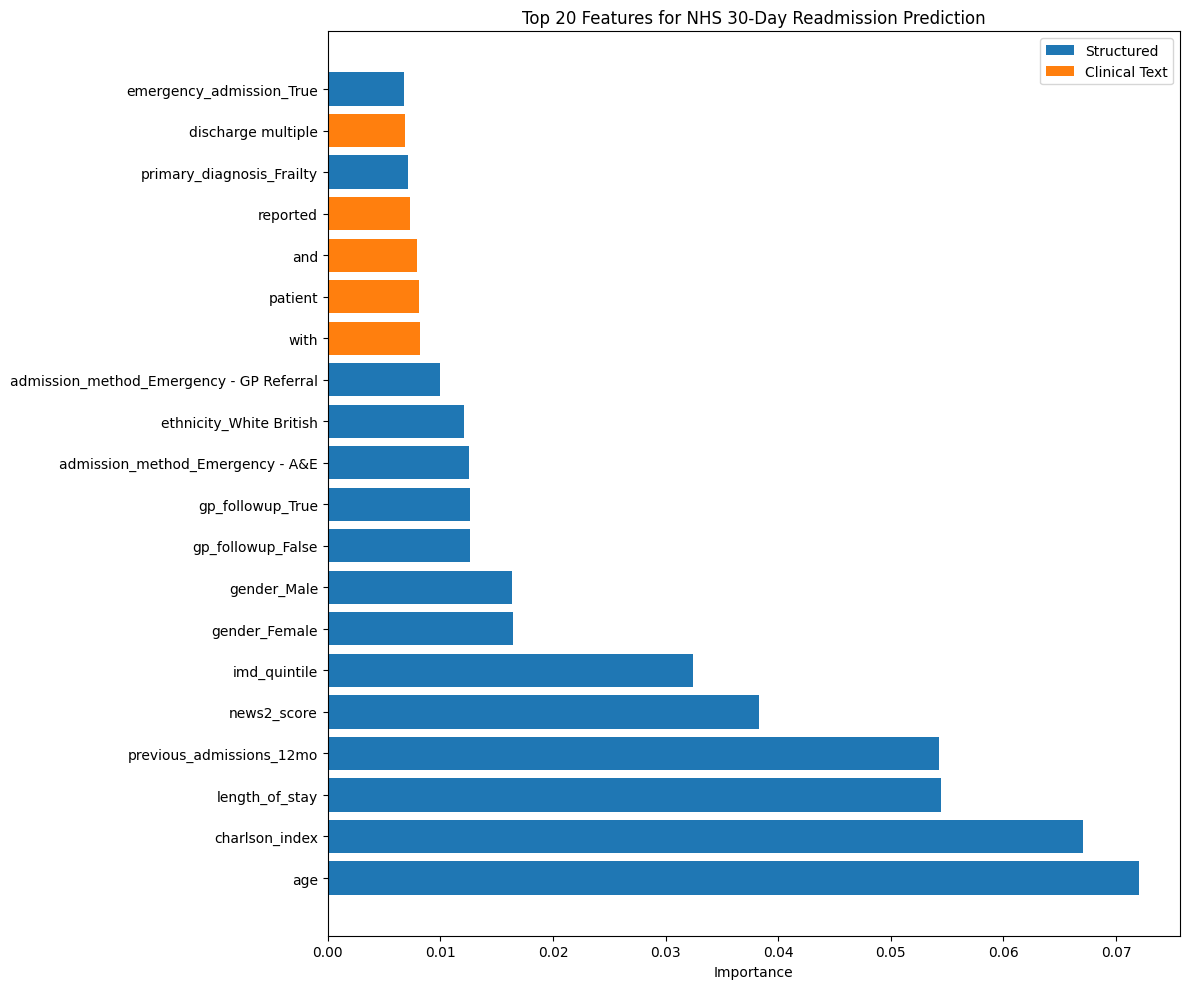

In [21]:
# 1.1 Load data
print("Loading NHS dataset...")
data = pd.read_csv('nhs_patient_data_with_notes.csv')
print(f"Loaded {len(data)} NHS patients with clinical notes")

# 1.2 Prepare structured + text features
# Removing 'note_length' from the list of columns to drop
X_structured = data.drop(['nhs_number', 'readmission_risk', 'readmitted_within_30d', 'clinical_note'], axis=1)
notes = data['clinical_note']
y = data['readmitted_within_30d']  # NHS 30-day readmission target

# 1.3 Train/test split
from sklearn.model_selection import train_test_split
X_structured_train, X_structured_test, notes_train, notes_test, y_train, y_test = train_test_split(
    X_structured, notes, y, test_size=0.2, random_state=42
)

# 1.4 Create and fit TF-IDF vectorizer for NHS clinical notes
print("Creating TF-IDF features from NHS clinical notes...")
tfidf = TfidfVectorizer(
    min_df=5,           # Ignore terms that appear in less than 5 documents
    max_df=0.5,         # Ignore terms that appear in more than 50% of documents
    ngram_range=(1, 2), # Include unigrams and bigrams
    max_features=240    # Limit features to prevent dimensionality issues
)

# Fit and transform on training data
X_text_train = tfidf.fit_transform(notes_train).toarray()
X_text_test = tfidf.transform(notes_test).toarray()

# Save the TF-IDF vectorizer for future use
joblib.dump(tfidf, 'nhs_tfidf_vectorizer.pkl')
print(f"Created {X_text_train.shape[1]} text features")

# Apply OneHotEncoding to structured data
# Identify categorical columns
categorical_cols = X_structured.select_dtypes(include=['object', 'bool']).columns.tolist()
print(f"Encoding {len(categorical_cols)} categorical columns: {categorical_cols}")

# Create OneHotEncoder instance
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform on training data
X_structured_train_encoded = encoder.fit_transform(X_structured_train[categorical_cols])

# Transform test data
X_structured_test_encoded = encoder.transform(X_structured_test[categorical_cols])

# Get feature names after encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create DataFrames for encoded data
X_structured_train_encoded = pd.DataFrame(X_structured_train_encoded, columns=encoded_feature_names, index=X_structured_train.index)
X_structured_test_encoded = pd.DataFrame(X_structured_test_encoded, columns=encoded_feature_names, index=X_structured_test.index)

# Concatenate encoded categorical features with numerical features
X_structured_train = pd.concat([X_structured_train.drop(columns=categorical_cols), X_structured_train_encoded], axis=1)
X_structured_test = pd.concat([X_structured_test.drop(columns=categorical_cols), X_structured_test_encoded], axis=1)
# ----> End of OneHotEncoding <----

# 1.5 Merge structured and text features
print(f"Combined feature space dimensions: {X_structured_train.shape[1]} structured + {X_text_train.shape[1]} text = {X_structured_train.shape[1] + X_text_train.shape[1]} total features")
X_train_combined = np.hstack([X_structured_train.values, X_text_train])
X_test_combined = np.hstack([X_structured_test.values, X_text_test])

# 1.6 Train RandomForest
print("\nTraining NHS combined model (structured + text features)...")
rf_model = RandomForestClassifier(n_estimators=120, random_state=42)
rf_model.fit(X_train_combined, y_train)

# 1.7 Evaluation
print("\nEvaluating NHS combined model...")
y_pred = rf_model.predict(X_test_combined)
y_pred_prob = rf_model.predict_proba(X_test_combined)[:, 1]

auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 1.8 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('NHS 30-Day Readmission - Combined Model')
plt.savefig('nhs_confusion_matrix_combined.png')
print("✅ NHS combined model confusion matrix saved.")

# 1.9 Feature importance analysis
def get_feature_importance(rf_model, structured_features, text_features):
    """Extract feature importance with proper feature names for combined model"""
    importances = rf_model.feature_importances_

    # Create feature names for combined model
    combined_features = list(structured_features.columns) + list(text_features)

    # Create DataFrame for easy sorting
    importance_df = pd.DataFrame({
        'feature': combined_features,
        'importance': importances
    })

    # Sort by importance
    importance_df = importance_df.sort_values('importance', ascending=False)

    # Add feature type
    importance_df['type'] = 'Structured'
    importance_df.loc[importance_df['feature'].isin(text_features), 'type'] = 'Text'

    return importance_df

# Get feature names from TF-IDF
text_features = tfidf.get_feature_names_out()

# Get combined feature importance
importance_df = get_feature_importance(rf_model, X_structured_train, text_features)

# Plot top 20 features
plt.figure(figsize=(12, 10))
top_features = importance_df.head(20)
# Create colormap based on feature type
colors = ['#1f77b4' if t == 'Structured' else '#ff7f0e' for t in top_features['type']]

plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Features for NHS 30-Day Readmission Prediction')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', label='Structured'),
    Patch(facecolor='#ff7f0e', label='Clinical Text')
]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig('nhs_feature_importance_combined.png')

# 1.10 Compare structured-only vs combined model
# Train a model with only structured features
print("\nTraining NHS structured-only model for comparison...")
rf_structured = RandomForestClassifier(n_estimators=100, random_state=42)
rf_structured.fit(X_structured_train.values, y_train)

# Evaluate
y_pred_structured = rf_structured.predict_proba(X_structured_test.values)[:, 1]
auc_structured = roc_auc_score(y_test, y_pred_structured)

print(f"\nModel comparison:")
print(f"Structured-only AUC: {auc_structured:.4f}")
print(f"Combined model AUC:  {auc:.4f}")
print(f"Improvement: {(auc - auc_structured) * 100:.2f}%")

# 1.11 Save the combined model
joblib.dump(rf_model, 'nhs_readmission_combined_model.pkl')
print("✅ NHS combined model saved successfully!")

# 1.12 Create evaluation function for clinical use
def predict_nhs_readmission_with_notes(patient_data, clinical_note):
    """
    Predict 30-day readmission risk for an NHS patient using structured data and clinical notes

    Args:
        patient_data: Dictionary with patient structured features
        clinical_note: String containing the clinical note

    Returns:
        Dictionary with risk prediction, key factors, and textual indicators
    """
    # Load required components
    model = joblib.load('nhs_readmission_combined_model.pkl')
    tfidf = joblib.load('nhs_tfidf_vectorizer.pkl')

    # Convert patient data to DataFrame if needed
    if not isinstance(patient_data, pd.DataFrame):
        patient_data = pd.DataFrame([patient_data])

    # Handle categorical encoding
    # Note: In production, this would need to match the training encoding exactly

    # Process the clinical note
    note_features = tfidf.transform([clinical_note]).toarray()

    # Combine features (simplified - production would need exact feature alignment)
    combined_features = np.hstack([patient_data.values, note_features])

    # Get prediction
    risk_prob = model.predict_proba(combined_features)[0, 1]
    risk_score = int(round(risk_prob * 100))

    # Determine risk category
    if risk_score < 25:
        risk_category = "Low"
    elif risk_score < 50:
        risk_category = "Moderate"
    elif risk_score < 75:
        risk_category = "High"
    else:
        risk_category = "Very High"

    # Find key textual indicators (simplified approach)
    text_indicators = []
    for term in tfidf.get_feature_names_out():
        if term in clinical_note.lower() and term in importance_df['feature'].values:
            text_indicators.append(term)

    return {
        "risk_probability": float(risk_prob),
        "risk_score": risk_score,
        "risk_category": risk_category,
        "text_indicators": text_indicators[:5]
    }

print("\nPrediction function ready for clinical deployment")